In [1]:
import pandas as pd 
import numpy as np
import os 
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

################################# 数据 读取-处理 开始#################################
sheet = pd.read_excel('data_input/USDCNY即期汇率.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.rename(columns={'人民币汇率收盘价':'USDCNY即期汇率'})
sheet.columns  

Index(['Date', 'USDCNY即期汇率', '美元指数', '中国与美国10年国债利差',
       '中国10年期国债收益率Non-Trend/F0.2', '金融机构外汇存款余额同比', '人民币汇率中间价上限(预测/最新)',
       '人民币汇率/收盘-中间', 'SGX UC连1-连13'],
      dtype='object')

In [4]:
sheet.head()

,Date,USDCNY即期汇率,美元指数,中国与美国10年国债利差,中国10年期国债收益率Non-Trend/F0.2,金融机构外汇存款余额同比,人民币汇率中间价上限(预测/最新),人民币汇率/收盘-中间,SGX UC连1-连13
0,1992-03-09,5.4613,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1992-03-10,5.4613,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1992-03-11,5.4613,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1992-03-12,5.4590,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1992-03-13,5.4618,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
sheet1 = pd.read_csv('data_output/美元指数_未来日度预测.csv')
sheet1.head()

,Date,美元指数_预测
0,2025-11-03,103.127964
1,2025-11-04,103.282232
2,2025-11-05,103.277300
3,2025-11-06,103.185300
4,2025-11-07,103.356040


In [6]:
sheet2 = pd.read_csv('data_output/中国10年期国债收益率_未来日度预测.csv')
sheet2.head()

,Date,中国10年期国债收益率
0,2025-11-03,1.684611
1,2025-11-04,1.686729
2,2025-11-05,1.688847
3,2025-11-06,1.690965
4,2025-11-07,1.693083


In [7]:
sheet3 = pd.read_csv('data_output/10年期美国国债收益率_未来日度预测.csv')
sheet3.head()

,Date,10年期美国国债收益率
0,2025-07-21,4.312182
1,2025-07-22,4.310981
2,2025-07-23,4.301545
3,2025-07-24,4.300076
4,2025-07-25,4.274597


In [8]:
sheet4 = pd.read_csv('data_output/中国10年期国债收益率Non-Trend-F0.2_未来日度预测.csv')
sheet4.head()

,Date,预测值_全量
0,2025-11-03,0.124075
1,2025-11-04,0.124075
2,2025-11-05,0.124075
3,2025-11-06,0.124075
4,2025-11-07,0.124075


In [9]:
# 确保 'Date' 列是 datetime 类型
sheet['Date'] = pd.to_datetime(sheet['Date'], errors='coerce')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
sheet4['Date'] = pd.to_datetime(sheet4['Date'], errors='coerce')
# 计算中国与美国10年国债利差
sheet2['中国与美国10年国债利差'] = sheet2['中国10年期国债收益率'] - sheet3['10年期美国国债收益率']

# 将美元指数预测值添加到sheet中
sheet_usd = pd.merge(sheet, sheet1[['Date', '美元指数_预测']], how='outer', left_on='Date', right_on='Date')
sheet['美元指数'] = sheet_usd['美元指数'].combine_first(sheet_usd['美元指数_预测'])

# 将国债利差添加到sheet中
sheet_spread = pd.merge(sheet, sheet2[['Date', '中国与美国10年国债利差']], how='outer', left_on='Date', right_on='Date')
sheet['中国与美国10年国债利差'] = sheet_spread['中国与美国10年国债利差_x'].combine_first(sheet_spread['中国与美国10年国债利差_y'])
# 将中国10年期国债收益率Trend/F0.2添加到sheet中
sheet_trend = pd.merge(sheet, sheet4[['Date', '预测值_全量']], how='outer', left_on='Date', right_on='Date')
sheet['中国10年期国债收益率Non-Trend/F0.2'] = sheet_trend['中国10年期国债收益率Non-Trend/F0.2'].combine_first(sheet_trend['预测值_全量'])

# 打印结果查看
sheet.tail()

,Date,USDCNY即期汇率,美元指数,中国与美国10年国债利差,中国10年期国债收益率Non-Trend/F0.2,金融机构外汇存款余额同比,人民币汇率中间价上限(预测/最新),人民币汇率/收盘-中间,SGX UC连1-连13
8960,2025-12-04,NaN,NaN,NaN,NaN,NaN,7.2298,NaN,NaN
8961,2025-12-05,NaN,NaN,NaN,NaN,NaN,7.2298,NaN,NaN
8962,2025-12-08,NaN,NaN,NaN,NaN,NaN,7.2298,NaN,NaN
8963,2025-12-09,NaN,NaN,NaN,NaN,NaN,7.2298,NaN,NaN
8964,2025-12-10,NaN,NaN,NaN,NaN,NaN,7.2298,NaN,NaN


In [10]:
sheet = sheet.set_index('Date')
last_day = sheet['USDCNY即期汇率'].last_valid_index()

In [11]:
sheet.columns

Index(['USDCNY即期汇率', '美元指数', '中国与美国10年国债利差', '中国10年期国债收益率Non-Trend/F0.2',
       '金融机构外汇存款余额同比', '人民币汇率中间价上限(预测/最新)', '人民币汇率/收盘-中间', 'SGX UC连1-连13'],
      dtype='object')

In [12]:
################################# 处理数据 让他们更适合 用来预测之后一个月的数据  #################################
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

################################# 处理缺失值 #################################
fill_methods = {
    '美元指数': 'interpolate',
    '中国与美国10年国债利差': 'interpolate',
    '中国10年期国债收益率Non-Trend/F0.2': 'interpolate',
    '金融机构外汇存款余额同比': 'interpolate',
    '人民币汇率中间价上限(预测/最新)': 'interpolate',
    '人民币汇率/收盘-中间' : 'interpolate' , 
    'SGX UC连1-连13': 'interpolate'                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, 'USDCNY即期汇率'] = sheet.loc[:last_day, 'USDCNY即期汇率'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['金融机构外汇存款余额同比_提前50天'] = sheet['金融机构外汇存款余额同比'].shift(190)


sheet['人民币汇率/收盘-中间_提前20天'] = sheet['人民币汇率/收盘-中间'].shift(20)  
sheet['SGX UC连1-连13_提前40天'] = sheet['SGX UC连1-连13'].shift(40)      
                                                                                         
sheet['中国与美国10年国债利差_逆序'] = reverse_column(sheet, '中国与美国10年国债利差')
sheet['中国10年期国债收益率Non-Trend/F0.2_逆序'] = reverse_column(sheet, '中国10年期国债收益率Non-Trend/F0.2')
sheet['金融机构外汇存款余额同比_提前50天_逆序'] = reverse_column(sheet, '金融机构外汇存款余额同比_提前50天')
#sheet['美国经济惊喜指数_提前45天_2023-04-01'] = np.where(
#    sheet.index >= pd.Timestamp('2023-04-01'),
#    sheet['美国经济惊喜指数_提前45天'],
#    np.nan
#)

################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['USDCNY即期汇率'].notna())
]

################################# 数据 读取-处理 结束 #################################

In [13]:
sheet.columns

Index(['USDCNY即期汇率', '美元指数', '中国与美国10年国债利差', '中国10年期国债收益率Non-Trend/F0.2',
       '金融机构外汇存款余额同比', '人民币汇率中间价上限(预测/最新)', '人民币汇率/收盘-中间', 'SGX UC连1-连13',
       '金融机构外汇存款余额同比_提前50天', '人民币汇率/收盘-中间_提前20天', 'SGX UC连1-连13_提前40天',
       '中国与美国10年国债利差_逆序', '中国10年期国债收益率Non-Trend/F0.2_逆序',
       '金融机构外汇存款余额同比_提前50天_逆序'],
      dtype='object')

In [14]:
sheet_daily

,Date,USDCNY即期汇率,美元指数,中国与美国10年国债利差,中国10年期国债收益率Non-Trend/F0.2,金融机构外汇存款余额同比,人民币汇率中间价上限(预测/最新),人民币汇率/收盘-中间,SGX UC连1-连13,金融机构外汇存款余额同比_提前50天,人民币汇率/收盘-中间_提前20天,SGX UC连1-连13_提前40天,中国与美国10年国债利差_逆序,中国10年期国债收益率Non-Trend/F0.2_逆序,金融机构外汇存款余额同比_提前50天_逆序
0,2023-01-02,6.920467,103.768300,-0.977467,0.111167,-0.142952,7.0923,-0.032733,0.1637,0.047927,0.0263,0.1987,0.327567,-0.276467,0.455073
1,2023-01-03,6.905000,104.657000,-0.948000,0.110900,-0.142504,7.0865,-0.042500,0.1625,0.043350,-0.0185,0.1888,0.298100,-0.276200,0.459650
2,2023-01-04,6.882500,104.266900,-0.878000,0.081700,-0.142057,7.0514,-0.030600,0.1647,0.038773,0.0122,0.1874,0.228100,-0.247000,0.464227
3,2023-01-05,6.873100,105.132400,-0.885800,0.094700,-0.141609,7.0305,-0.019500,0.1689,0.034195,-0.0108,0.1631,0.235900,-0.260000,0.468805
4,2023-01-06,6.858800,103.910400,-0.715700,0.105500,-0.141161,7.0290,-0.032400,0.1720,0.029618,0.0192,0.1564,0.065800,-0.270800,0.473382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,2025-11-24,NaN,103.042476,-2.418110,0.089183,0.199800,7.2298,0.025500,0.1425,0.131510,0.0228,0.1472,1.768210,-0.254483,0.371490
768,2025-11-25,NaN,103.130476,-2.405999,0.089183,0.199800,7.2298,0.025500,0.1425,0.132762,0.0150,0.1460,1.756099,-0.254483,0.370238
769,2025-11-26,NaN,103.190776,-2.420802,0.089183,0.199800,7.2298,0.025500,0.1425,0.134014,0.0148,0.1464,1.770902,-0.254483,0.368986
770,2025-11-27,NaN,103.092076,-2.436821,0.074425,0.199800,7.2298,0.025500,0.1425,0.135267,0.0243,0.1433,1.786921,-0.239725,0.367733


In [15]:
################################# 因子平滑处理 #################################
# 对主要因子进行平滑处理
smooth_window = 7  # 设置平滑窗口大小

# 平滑处理函数
def smooth_series(series):
    return series.rolling(window=smooth_window, min_periods=1).mean()

# 对指定的因子进行平滑
sheet_daily['金融机构外汇存款余额同比_提前50天_逆序'] = smooth_series(sheet_daily['金融机构外汇存款余额同比_提前50天_逆序'])
sheet_daily['美元指数'] = smooth_series(sheet_daily['美元指数'])
sheet_daily['中国与美国10年国债利差_逆序'] = smooth_series(sheet_daily['中国与美国10年国债利差_逆序'])
sheet_daily['中国10年期国债收益率Non-Trend/F0.2_逆序'] = smooth_series(sheet_daily['中国10年期国债收益率Non-Trend/F0.2_逆序'])
sheet_daily['人民币汇率/收盘-中间_提前20天'] = smooth_series(sheet_daily['人民币汇率/收盘-中间_提前20天'])
sheet_daily['SGX UC连1-连13_提前40天'] = smooth_series(sheet_daily['SGX UC连1-连13_提前40天'])


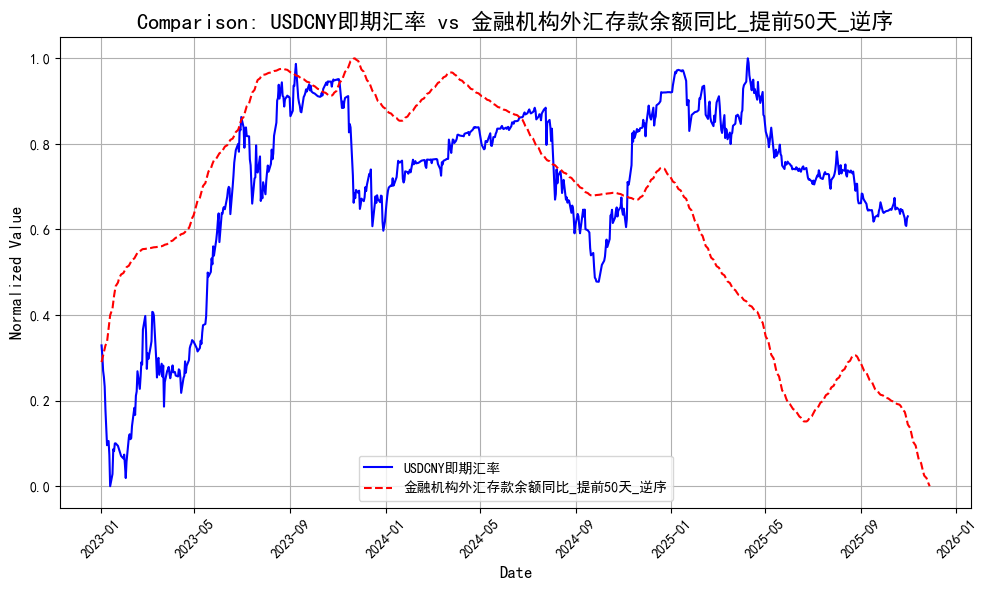

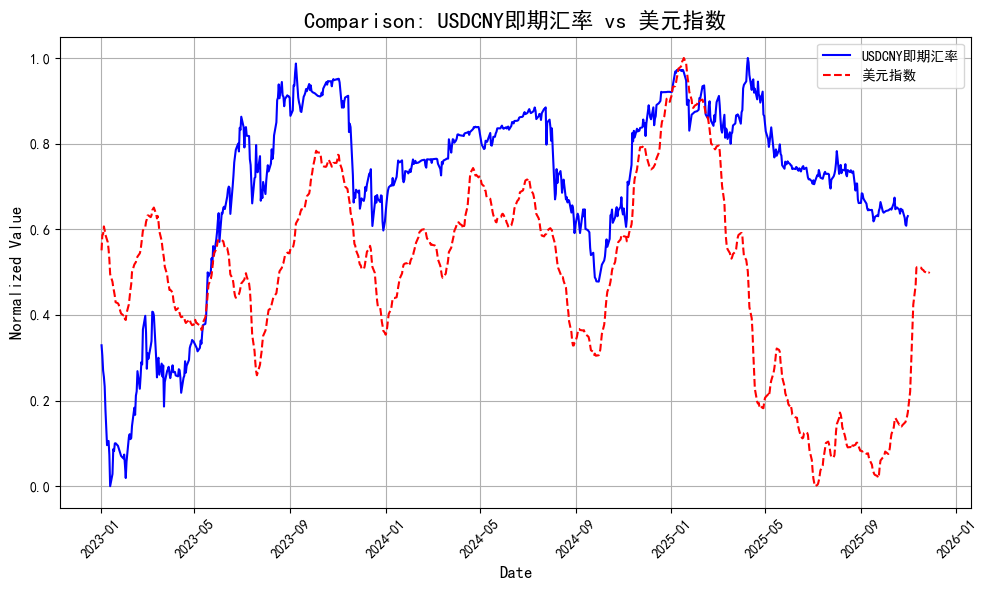

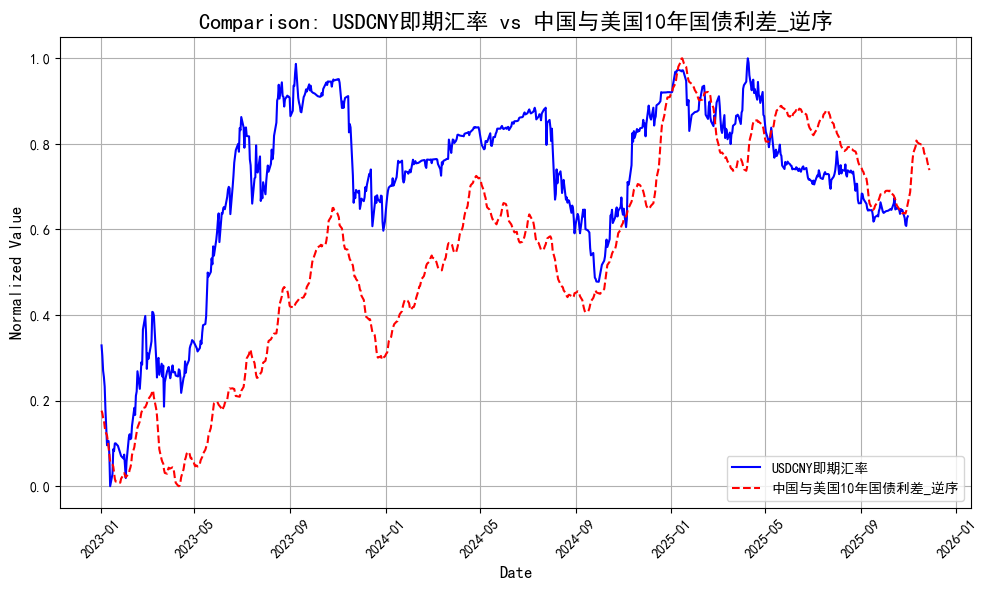

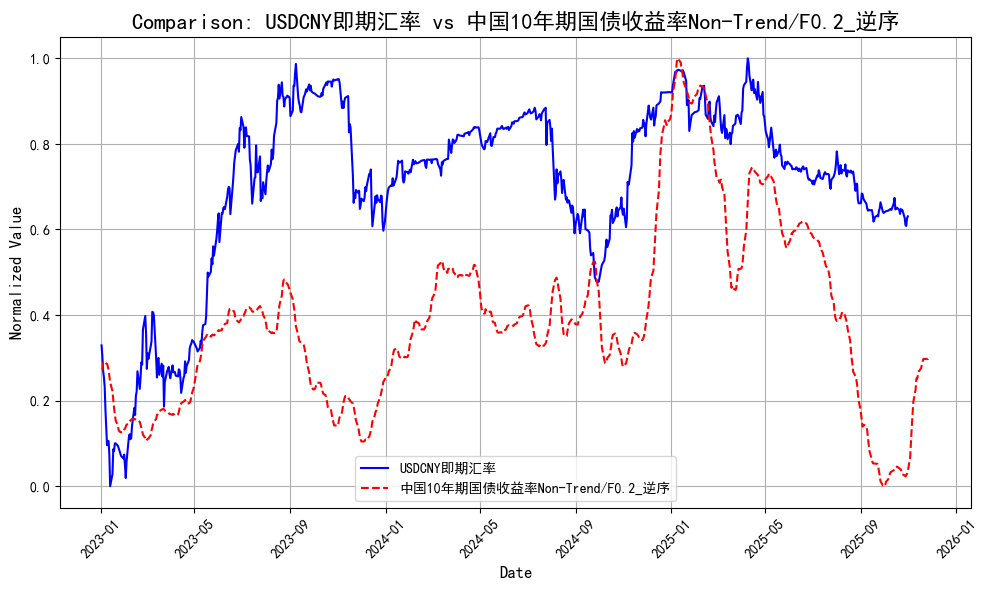

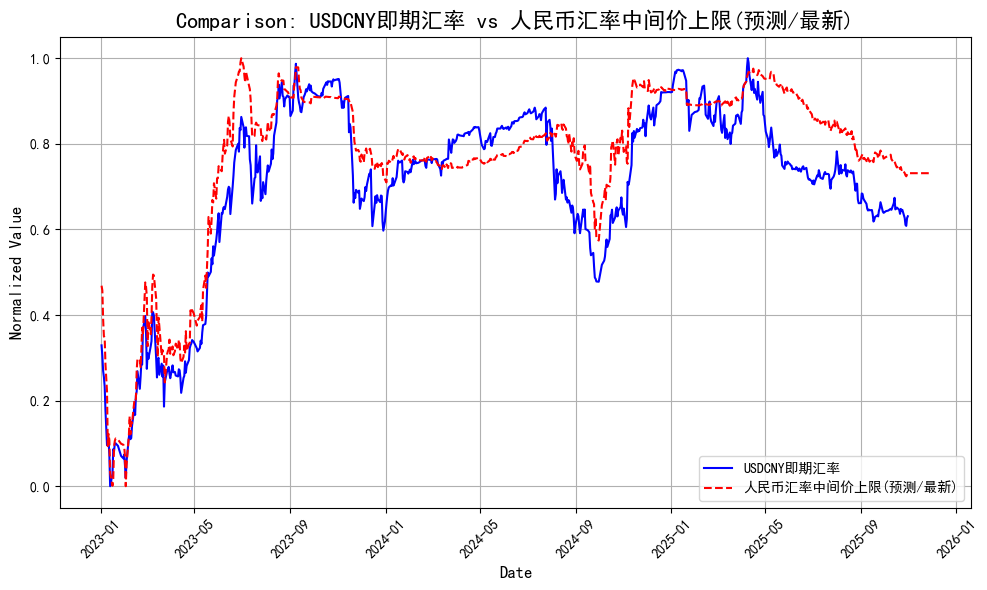

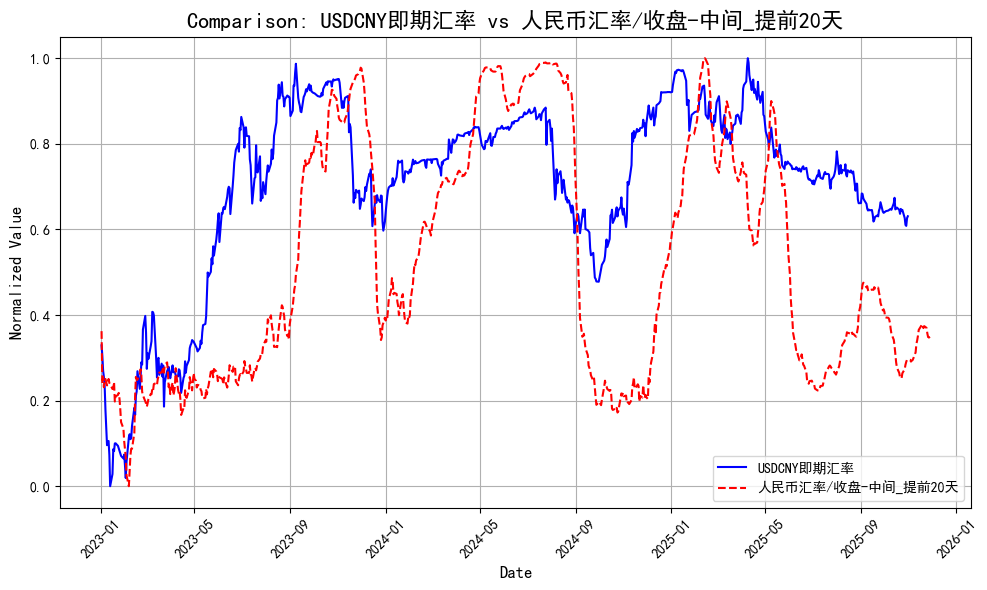

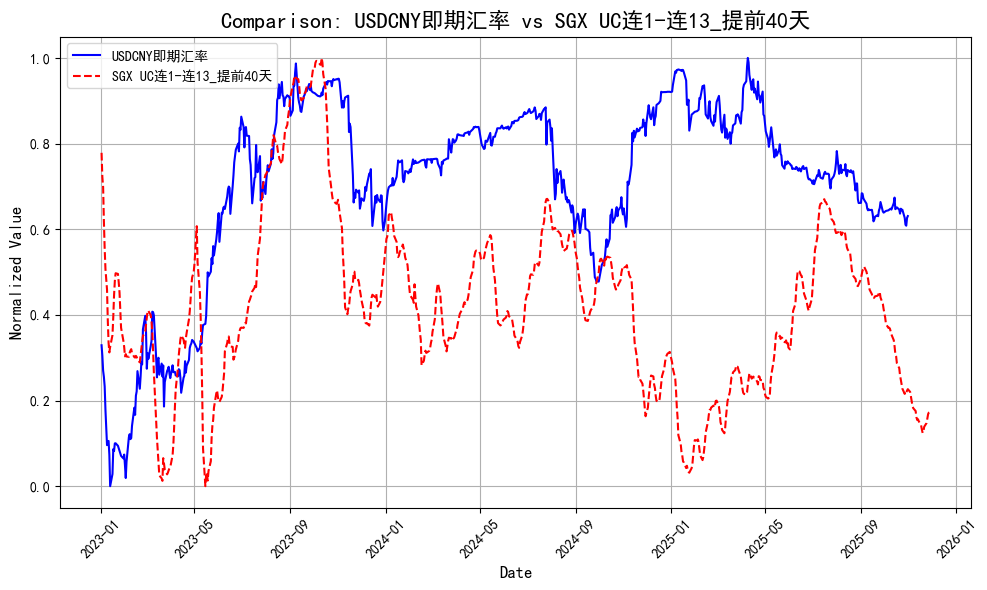

In [16]:
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='USDCNY即期汇率', 
    compare_cols=['金融机构外汇存款余额同比_提前50天_逆序', '美元指数', '中国与美国10年国债利差_逆序',
       '中国10年期国债收益率Non-Trend/F0.2_逆序', '人民币汇率中间价上限(预测/最新)','人民币汇率/收盘-中间_提前20天', 'SGX UC连1-连13_提前40天'
       ]
)

In [17]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 30
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
    '金融机构外汇存款余额同比_提前50天_逆序',
    '美元指数',
    '中国与美国10年国债利差_逆序',
    '中国10年期国债收益率Non-Trend/F0.2_逆序',
    #'人民币汇率/收盘-中间_提前20天', 
    'SGX UC连1-连13_提前40天',

]

predict_column = 'USDCNY即期汇率'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,  # 较小的学习率
    'max_depth': 7,  # 控制树的深度防止过拟合
    'min_child_weight': 2,  # 控制过拟合
    'subsample': 0.8,  # 随机采样防止过拟合
    'colsample_bytree': 0.8,  # 特征随机采样
    'gamma': 0,  # 控制分裂
    'reg_alpha': 0.1,  # L1正则化
    'reg_lambda': 1,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
}

num_boost_round = 1000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:0.04966	train-rmse:0.12852


[500]	eval-rmse:0.01911	train-rmse:0.01138


[999]	eval-rmse:0.01803	train-rmse:0.00908


训练集 MSE (DMatrix): 0.0001, 训练集 R² (DMatrix): 0.9955
测试集 MSE (DMatrix): 0.0003, 测试集 R² (DMatrix): -3.5767


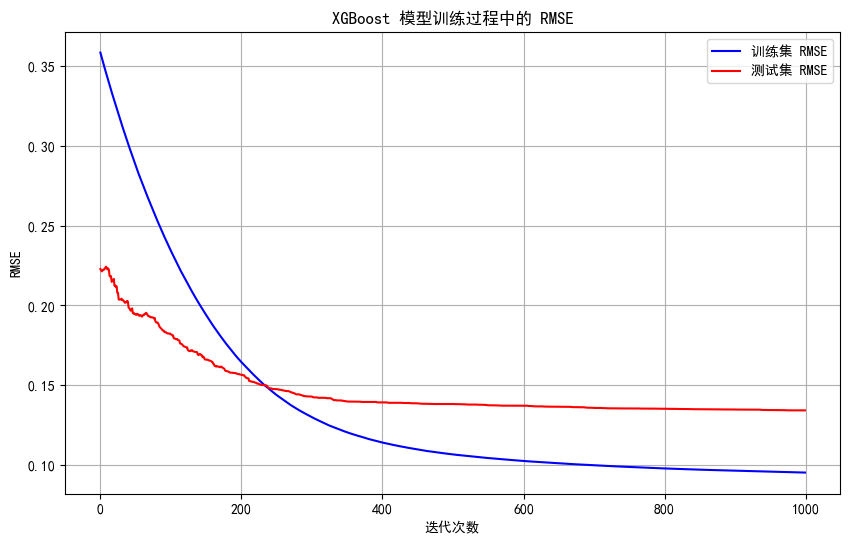

In [18]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=200,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:0.13490


[500]	train-rmse:0.01128


[999]	train-rmse:0.00885


全部数据 MSE: 0.0001, 全部数据 R²: 0.9958


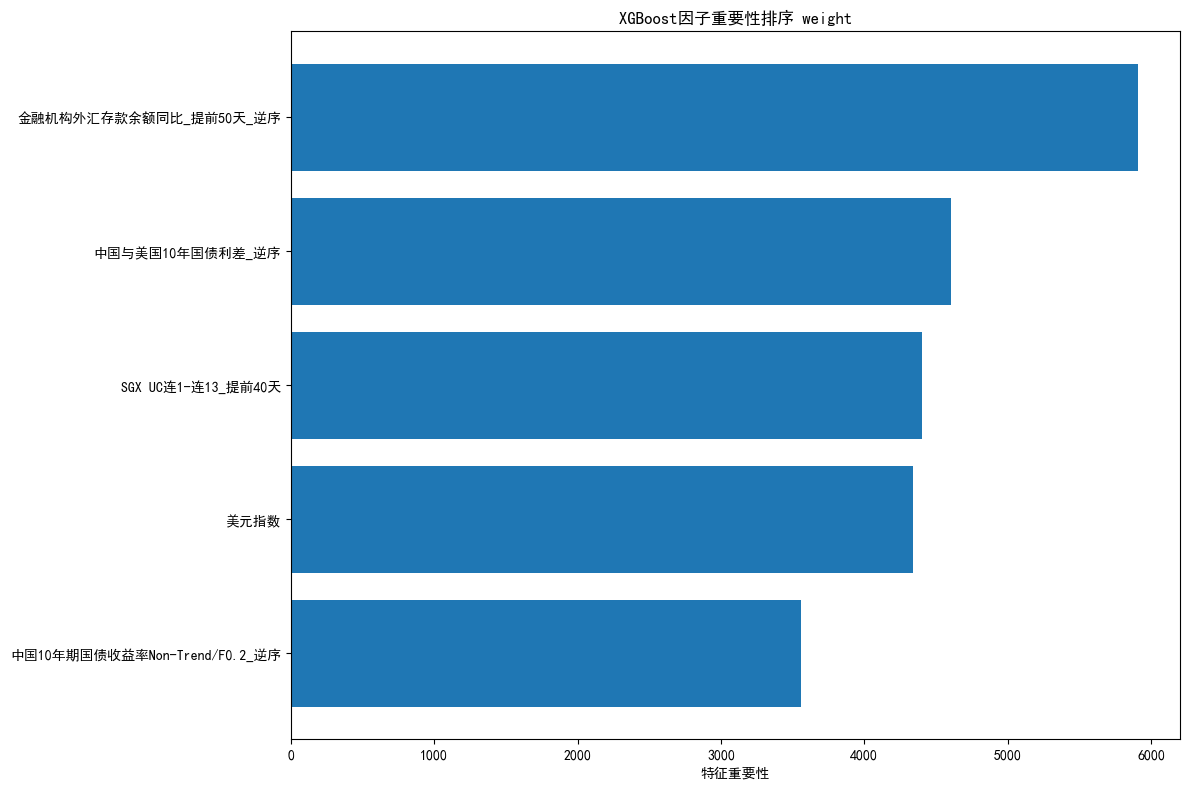

In [20]:
# 创建特征重要性排序的DataFrame
plt.figure(figsize=(12, 8))
importance_type = 'weight'
feature_importance = model_all.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 weight')
plt.tight_layout()
plt.show()


Gap between last actual value and first prediction: -0.0015045394897459374


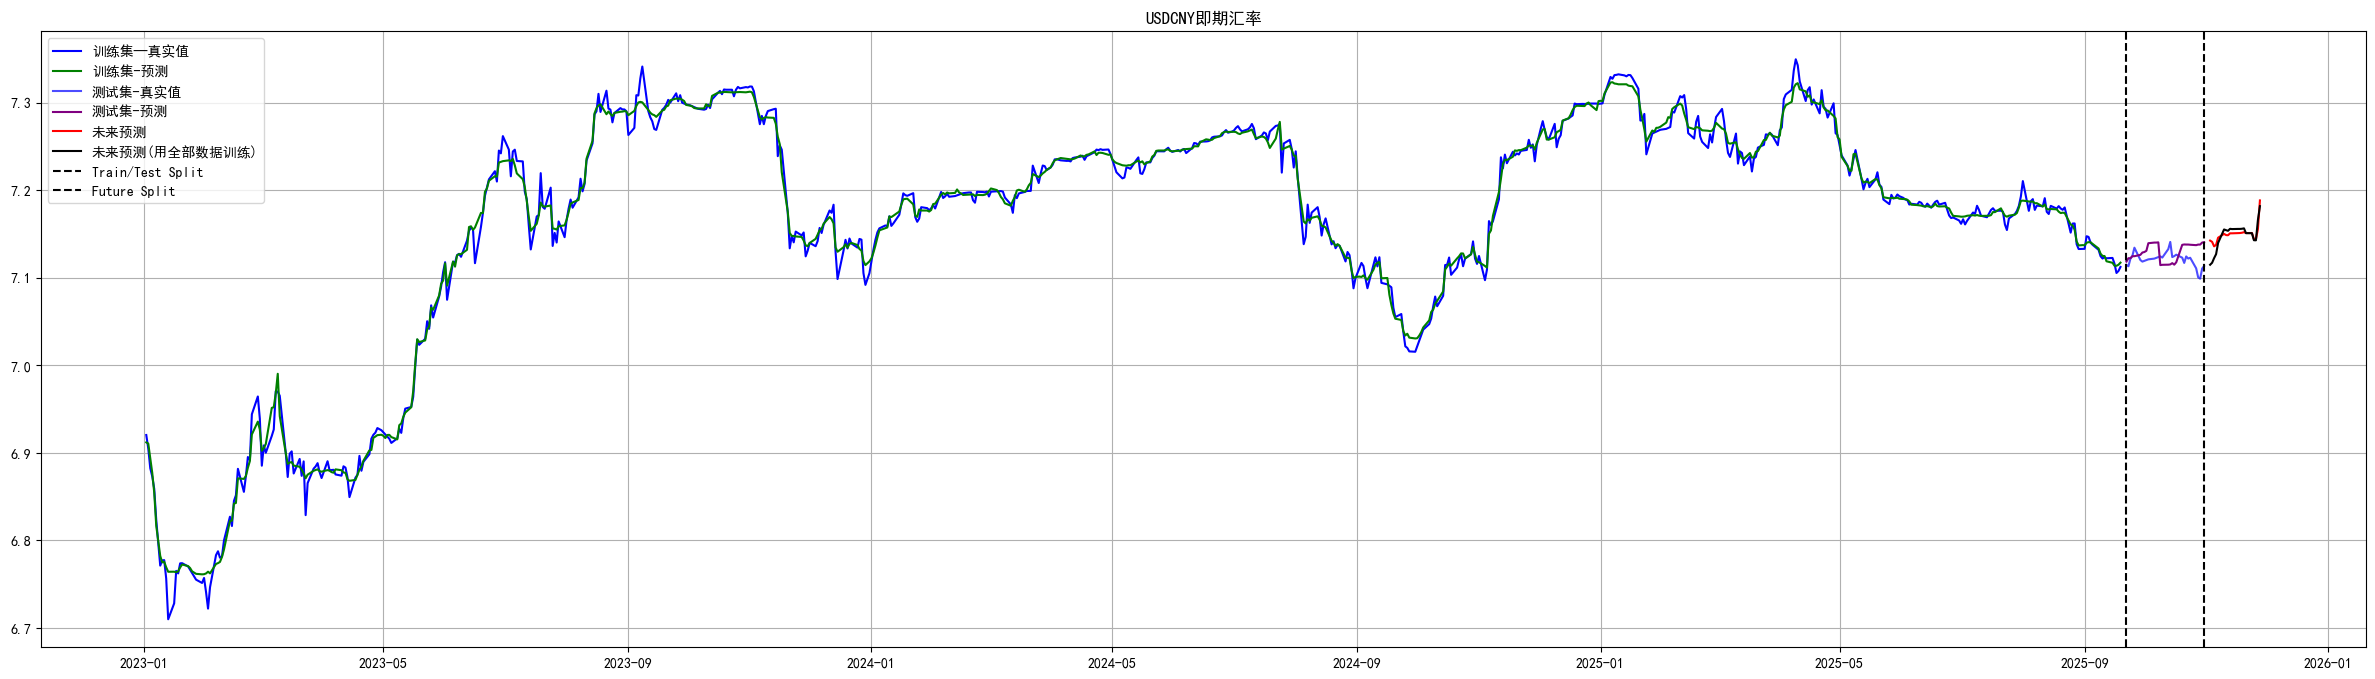

In [21]:
################################# 可视化 #################################
# 创建一个新的图形
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('USDCNY即期汇率')
plt.legend()
plt.grid(True)
plt.show()

---

In [22]:
################################# 训练预测数据 excel格式输出  #################################

############ 日度 数据 ############
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})

historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})

merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/USDCNY即期汇率_合并数据.xlsx', index=False,float_format='%.4f')

############ 月度 数据 ############
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
test_pred_2024 = test_data[['Date', '预测值']].copy()
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/USDCNY即期汇率_月度数据.xlsx', index=False,float_format= '%.4f')

In [23]:
merged_df_monthly

,Date,真实值,预测值
34,2025/11/30,NaN,7.147916
33,2025/10/31,7.120487,7.131124
32,2025/09/30,7.124745,7.126088
31,2025/08/31,7.173100,7.172282
30,2025/07/31,7.172661,7.173152
29,2025/06/30,7.182020,7.181949
28,2025/05/31,7.211609,7.211998
27,2025/04/30,7.302827,7.297691
26,2025/03/31,7.250790,7.252493
25,2025/02/28,7.276761,7.278766


In [24]:
merged_df_daily


,Date,真实值,预测值
771,2025/11/28,NaN,7.181975
770,2025/11/27,NaN,7.166207
769,2025/11/26,NaN,7.142933
768,2025/11/25,NaN,7.143030
767,2025/11/24,NaN,7.151055
...,...,...,...
4,2023/01/06,6.858800,NaN
3,2023/01/05,6.873100,NaN
2,2023/01/04,6.882500,NaN
1,2023/01/03,6.905000,NaN


---

In [25]:
huilv_daily_pred = future_pred_daily.copy()
huilv_daily_pred = huilv_daily_pred.rename(columns={'预测值': 'USDCNH:即期汇率_预测'})


try:
    save_path = os.path.expanduser("~/Desktop/X-BASE/汽柴煤油2.0/data_output_auto")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
except:
    save_path = os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/汽柴煤油2.0/data_output_auto") 
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
huilv_daily_pred.to_csv(f'{save_path}/人民币汇率_未来日度预测.csv', index=False)
huilv_daily_pred.tail()

,Date,USDCNH:即期汇率_预测
767,2025-11-24,7.151055
768,2025-11-25,7.143030
769,2025-11-26,7.142933
770,2025-11-27,7.166207
771,2025-11-28,7.181975


In [26]:
huilv_daily_pred_monthly = merged_df_monthly[['Date','预测值']].copy()
huilv_daily_pred_monthly = huilv_daily_pred_monthly.rename(columns={'预测值': 'USDCNH:即期汇率_预测'})
huilv_daily_pred_monthly.to_csv(f'{save_path}/人民币汇率2024年月度预测.csv', index=False)
huilv_daily_pred_monthly.head()

,Date,USDCNH:即期汇率_预测
34,2025/11/30,7.147916
33,2025/10/31,7.131124
32,2025/09/30,7.126088
31,2025/08/31,7.172282
30,2025/07/31,7.173152


---

In [27]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "USDCNY即期汇率"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [28]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "USDCNY即期汇率"

# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [29]:
'''
from Ecel import generate_and_fill_excel
success = generate_and_fill_excel(
    daily_df =  merged_df_daily,
    target_name = 'LME铜价',        # 写入的"预测标的"显示名
    TARGET_COL = '预测值',
    output_path='update.xlsx'
)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfrom Ecel import generate_and_fill_excel\nsuccess = generate_and_fill_excel(\n    daily_df =  merged_df_daily,\n    target_name = \'LME铜价\',        # 写入的"预测标的"显示名\n    TARGET_COL = \'预测值\',\n    output_path=\'update.xlsx\'\n)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'